<div style="text-align: center;">
    <img src="https://user-images.githubusercontent.com/86345471/221379942-51f24819-1f76-4289-8dee-06ea69f730f6.png" alt=Main "KPI />
</di>

<hr>

**Завдання:** Зробити парсинг певної соцмережі (фейсбук, тредс, Х чи т.п.) та  створити БД для виявлення певних повідомлень (ключових слів). Зробити аналіз на виявлення аномальної поведінки(наприклад використання тригерних слів). Як розширення – якщо аналітика вивлиться інформтивною – виявляти ботів.

**Теорія:** Парсинг соціальних мереж є процесом автоматизованого збору даних із відкритих джерел, таких як коментарі під дописами користувачів. Для цього використовуються API-методи, що дозволяють отримувати структуровані дані, що зберігатимуться у базі даних для подальшого аналізу. Одним із напрямів обробки таких даних є виявлення повідомлень, що містять заздалегідь визначені ключові або тригерні слова, які можуть сигналізувати про специфічний контекст або наявність інформаційного впливу. Подальший аналіз поведінкових характеристик користувачів (частота публікацій, активність у нічний час, середня довжина коментарів тощо) дозволяє здійснювати ідентифікацію аномальної або підозрілої активності, зокрема виявлення автоматизованих або бото-подібних акаунтів.

<hr>

### 1. 📦 Імпорт бібліотек та модулів

In [1]:
import praw

import sqlite3
import pandas as pd

from datetime import datetime
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt

### 2. 🌐 Отримання дописів із Reddit

In [2]:
client_id = "jM8Jm6I6Z-Lc_o_R1P4DKw"
client_secret = "C79uVX4fnzyJragangyHZWTDDYy-ng"
user_agent = "reddit-analysis-script/0.1"

reddit = praw.Reddit(
    client_id=client_id,
    client_secret=client_secret,
    user_agent=user_agent
)

In [3]:
keywords = ["Zelensky"]
subreddit_name = "worldnews"

limit_posts = 1000
comments_data = []

matched_posts = 0 

for i, submission in enumerate(reddit.subreddit(subreddit_name).new(limit=limit_posts), start=1):
    print(f"[{i}] Fetching comments from post: \"{submission.title}\"")

    submission.comments.replace_more(limit=0)
    found_in_this_post = False

    for comment in submission.comments.list():
        text = comment.body.lower()

        if any(word.lower() in text for word in keywords):
            comments_data.append({
                "post_id": submission.id,
                "post_title": submission.title,
                "comment_id": comment.id,
                "comment_body": comment.body,
                "author": str(comment.author),
                "created_utc": comment.created_utc,
                "score": comment.score
            })
            found_in_this_post = True

    if found_in_this_post:
        matched_posts += 1

[1] Fetching comments from post: "China rebuts Japan's assertion of airspace intrusion near Senkakus"
[2] Fetching comments from post: "Trump ‘delighted’ by his influence on Canada’s election: U.S. journalist - National | Globalnews.ca"
[3] Fetching comments from post: "Trump on Iran Nuclear Talks: Goal is "Complete Dismantlement", but open to hearing about "Civilian" nuclear program"
[4] Fetching comments from post: "Trump still would like to add Canada and Greenland but says attack on Canada ‘highly unlikely’"
[5] Fetching comments from post: "Netanyahu vows to retaliate against Houthis and Iran after missile attack"
[6] Fetching comments from post: "Czech president: We are discussing artillery shell supplies to Ukraine for 2026"
[7] Fetching comments from post: "Trump mostly — but not entirely — rules out military action on Canada"
[8] Fetching comments from post: ""There may be": Zelenskyy commented on possible provocations by Russia on May 9 in Moscow | УНН"
[9] Fetching comments 

In [4]:
df = pd.DataFrame(comments_data)
df.sample(10)

,post_id,post_title,comment_id,comment_body,author,created_utc,score
30,1kegdat,Zelenskyy: Trump says Russia won’t touch Ukrai...,mqinw7z,Tomorrow Trump will tell Zelenskyy something d...,Smrleda,1.746357e+09,1
119,1keb2ac,/r/WorldNews Live Thread: Russian Invasion of ...,mqhwjx5,"Zelensky is not very tall either, what’s your ...",helm,1.746340e+09,14
772,1k5ut44,High-profile Ukraine peace talks collapse,monhz3q,Hmmm Ukraine has to negotiate for which parts ...,TheMobster100,1.745433e+09,1
293,1kbw086,Carney reiterates commitment to Ukraine in cal...,mpxsy89,News article:\nOTTAWA - Canadian Prime Ministe...,AndroidOne1,1.746060e+09,27
301,1kbsio0,US and Ukraine sign natural resources deal and...,mpx6fnk,Zelenskyy is far too smart to let himself get ...,doorbell2021,1.746052e+09,48
264,1kc56ej,"Russia ignores the ceasefire proposal, attacki...",mq1cb21,The example u gave isn't really at all relevan...,Additional_Thanks927,1.746115e+09,-3
185,1kdilgq,Reform UK makes big gains in English local ele...,mqbzvnw,Is it just me or is Farage turning orange\n\nA...,Hellstorm901,1.746255e+09,26
202,1kdifc7,Zelenskyy vows to make Russia “feel the war” a...,mqdm8eh,"Not exactly *weak*, but ""unable to win the war...",Trama-D,1.746283e+09,1
497,1k8nbki,Ukrainians gather in Pripyat to pay tribute to...,mpcsbr9,need to honor the zelensky victims,EsculhambadorDeGados,1.745779e+09,-8
620,1k6uzmr,Trump says he is 'not happy' with deadly Russi...,moty85m,Russia has been doing deadly strikes for 3 yea...,Oerthling,1.745519e+09,1


### 3. 🗃️ Створення SQLite БД (In-Memory)

In [5]:
conn = sqlite3.connect(":memory:")

create_table_sql = """
CREATE TABLE IF NOT EXISTS reddit_posts (
    post_id TEXT,
    post_title TEXT,
    comment_id TEXT PRIMARY KEY,
    comment_body TEXT,
    author TEXT,
    created_utc REAL,
    score INTEGER
)
"""
conn.execute(create_table_sql)
conn.commit()

In [6]:
try:
    df.to_sql("reddit_posts", conn, index=False, if_exists="append")
except sqlite3.IntegrityError:
    print("⚠️ Unable to insert comment that was added before!")

In [7]:
db = pd.read_sql("SELECT * FROM reddit_posts", conn)
db

,post_id,post_title,comment_id,comment_body,author,created_utc,score
0,1keor89,Trump still would like to add Canada and Green...,mqkgd9a,Canada here: Tuesday our Prime Minister will b...,CrazyRevolutionary96,1.746380e+09,1
1,1kenvxh,Trump mostly — but not entirely — rules out mi...,mqk9ap9,I think you would have to make that a conditio...,Little_Blue_Marble,1.746378e+09,1
2,1kenvxh,Trump mostly — but not entirely — rules out mi...,mqkfd32,I don't really know if there is a good way to ...,BrgQun,1.746379e+09,1
3,1kenvxh,Trump mostly — but not entirely — rules out mi...,mqkf9n0,"I know it would never happen, but I think it w...",AdAdventurous2597,1.746379e+09,1
4,1kegdat,Zelenskyy: Trump says Russia won’t touch Ukrai...,mqjd2qm,Zelenskyy knows better than to trust Trump. I ...,pripjat,1.746367e+09,67
...,...,...,...,...,...,...,...
805,1k5rmx0,Ukraine War: London peace talks downgraded as ...,mokc8i6,If Zelenskyy wants to fight this war for anoth...,Zhukov-74,1.745388e+09,-50
806,1k5rmx0,Ukraine War: London peace talks downgraded as ...,molj89c,"Ah, see, there's a difference. Ukrainian const...",ced_rdrr,1.745412e+09,14
807,1k5rmx0,Ukraine War: London peace talks downgraded as ...,momzp49,The USA has methods to update its constitution...,kooshipuff,1.745428e+09,5
808,1k5rmx0,Ukraine War: London peace talks downgraded as ...,mokehna,Zelenskyy doesn’t have to flatter and blow som...,ONLY_SAYS_ONLY,1.745389e+09,21


### 4. 🚨 Виявлення тригерних (осудливих) cлів

In [8]:
trigger_words = [
    "traitor", "corrupt", "liar", "dictator", "puppet", "clown", "incompetent",
    "shame", "kremlin agent", "failure", "fake", "murderer", "occupier",
    "authoritarian", "regime", "repression", "persecution", "totalitarian",
    "loser", "infantile", "criminal", "sellout", "nazi", "warmonger", "mobster"
]


def detect_trigger_words(text):
    text = text.lower()
    return any(word in text for word in trigger_words)

In [9]:
db["is_triggered"] = df["comment_body"].apply(detect_trigger_words)
db_triggered = db[db["is_triggered"] == True]
db_triggered

,post_id,post_title,comment_id,comment_body,author,created_utc,score,is_triggered
9,1kegdat,Zelenskyy: Trump says Russia won’t touch Ukrai...,mqjx5jq,Zelensky. Poor guy. Having no other option but...,Equivalent_Kick9858,1.746374e+09,3,True
46,1kegdat,Zelenskyy: Trump says Russia won’t touch Ukrai...,mqjix6u,Zelenskyy never should have signed that minera...,Agitated-Isopod10,1.746369e+09,1,True
47,1kegdat,Zelenskyy: Trump says Russia won’t touch Ukrai...,mqjjdko,"First off, I'm sure Zelenskyy doesn't believe ...",Harry_Mud,1.746370e+09,1,True
71,1kegdat,Zelenskyy: Trump says Russia won’t touch Ukrai...,mqk209d,Zelensky thinks he can manipulate Trump. I am ...,SweetAlyssumm,1.746375e+09,1,True
73,1kegdat,Zelenskyy: Trump says Russia won’t touch Ukrai...,mqiv1oj,Exactly… allow me to add to this and let’s jus...,billshermanburner,1.746360e+09,23,True
...,...,...,...,...,...,...,...,...
732,1k63ulv,Ukraine talks downgraded in London as Kyiv rej...,moqsrpo,Zelensky should simply stop wasting his time w...,IDKandIDC5585,1.745474e+09,-4,True
750,1k63kei,'This is a very dangerous moment' — Zelensky w...,moppoo7,There were also millions of former democrats t...,TeaAndLifting,1.745458e+09,11,True
768,1k5ut44,High-profile Ukraine peace talks collapse,molbtl6,"Once again, Zelenskyy comes out looking like t...",illarionds,1.745409e+09,8,True
772,1k5ut44,High-profile Ukraine peace talks collapse,monhz3q,Hmmm Ukraine has to negotiate for which parts ...,TheMobster100,1.745433e+09,1,True


### 5. 📈 Аналіз частоти тригерних твітів

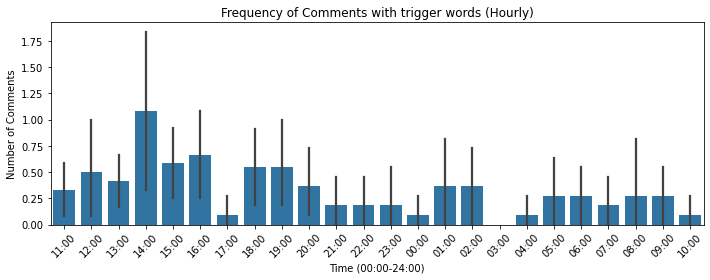

In [10]:
db["created_at"] = pd.to_datetime(db["created_utc"], unit="s")
db = db.set_index("created_at")

trigger_freq = db[db["is_triggered"]].resample("1H").size()

plt.figure(figsize=(10, 4))
sns.barplot(x=trigger_freq.index.strftime("%H:%M"), y=trigger_freq.values)
plt.xticks(rotation=45)

plt.title("Frequency of Comments with trigger words (Hourly)")
plt.xlabel("Time (00:00-24:00)")
plt.ylabel("Number of Comments")

plt.tight_layout()

### 6. 📊 Загальні висновки по коментарях

In [11]:
print(f"🔍 Total comments analyzed: {len(db)}")
print(f"⚠️ Comments with trigger words: {len(db_triggered)} ({len(db_triggered) / len(db):.2%})")

trigger_counter = Counter()
for text in db_triggered["comment_body"]:
    words = text.lower().split()
    trigger_counter.update([w for w in words if w in trigger_words])

print("\n🔥 Top 5 trigger words:")
for word, count in trigger_counter.most_common(5):
    print(f" - {word}: {count}")

top_authors = db_triggered["author"].value_counts().head(5)
print("\n👤 Top authors by number of triggered comments:")
print(top_authors)

print("\n📝 Sample Triggered Comments:\n" + "-"*40)
for i, row in db_triggered.sample(5).iterrows():
    comment = row["comment_body"].replace("\n", " ")
    comment = (comment[:300] + "...") if len(comment) > 300 else comment
    print(f"🔢 {i+1}\n👤 {row['author']}\n💬 {comment}\n")

🔍 Total comments analyzed: 810
⚠️ Comments with trigger words: 91 (11.23%)

🔥 Top 5 trigger words:
 - dictator: 12
 - fake: 6
 - criminal: 6
 - puppet: 6
 - corrupt: 4

👤 Top authors by number of triggered comments:
M795                   5
JohnBPrettyGood        2
Aware-Chipmunk4344     2
Axelrad77              2
Equivalent_Kick9858    1
Name: author, dtype: int64

📝 Sample Triggered Comments:
----------------------------------------
🔢 85
👤 42nu
💬 It's funny.  Trump calls Zelensky a dictator, but Trump *loves* dictators, so you know right away that even he doesn't think it's true.

🔢 537
👤 Jamaz
💬 I also doubt he works directly under Russia, but he's still loyal to Russia out of admiration for Putin's authoritarian wealth and power while being a vindictive asshole about Zelensky's refusal to fabricate lies about Biden in 2020. He adores and wants to emulate Putin in every way. So he's even wo...

🔢 227
👤 CheshireCat78
💬 This is a good thing. It means they are giving up on Putin agreei

### **. 🤖 Виявлення ботів (спрощена логіка)

In [12]:
db["created_at"] = pd.to_datetime(db["created_utc"], unit="s")

db["hour"] = db["created_at"].dt.hour
db["day"] = db["created_at"].dt.date

bot_users = []
grouped = db.groupby("author")

for author, group in grouped:
    if len(group) < 5:
        continue

    trigger_count = group["is_triggered"].sum()
    short_count = (group["comment_body"].str.len() < 10).sum()
    night_count = group[(group["hour"] >= 0) & (group["hour"] <= 5)].shape[0]

    trigger_ratio = trigger_count / len(group)
    short_ratio = short_count / len(group)
    night_ratio = night_count / len(group)

    if (
        trigger_ratio > 0.18 or
        short_ratio > 0.24 or
        night_ratio > 0.32
    ):
        bot_users.append(author)

db["is_bot"] = db["author"].isin(bot_users)

print(f"|☼☼| Detected {len(bot_users)} potential bot accounts!")
print(f"=++= Suspicious users: {bot_users}\n\n")

suspicious_df = db[db["is_bot"]].sort_values(by="author")
suspicious_df.head()

|☼☼| Detected 2 potential bot accounts!
=++= Suspicious users: ['Useful-Scratch-72', 'cuterebro']




,post_id,post_title,comment_id,comment_body,author,created_utc,score,is_triggered,created_at,hour,day,is_bot
created_at,,,,,,,,,,,,
2025-05-04 06:01:20,1keb2ac,/r/WorldNews Live Thread: Russian Invasion of ...,mqhtebb,Zelensky says he won’t play Putin’s ‘games’ wi...,Useful-Scratch-72,1.746338e+09,50,False,2025-05-04 06:01:20,6,2025-05-04,True
2025-04-26 13:58:52,1k8465j,/r/WorldNews Live Thread: Russian Invasion of ...,mp5asyz,Trump and Zelensky have a ‘productive meeting’...,Useful-Scratch-72,1.745676e+09,21,False,2025-04-26 13:58:52,13,2025-04-26,True
2025-04-26 14:08:02,1k8465j,/r/WorldNews Live Thread: Russian Invasion of ...,mp5cejj,Another update on Trump Zelensky meeting.\n\nh...,Useful-Scratch-72,1.745676e+09,22,False,2025-04-26 14:08:02,14,2025-04-26,True
2025-04-26 05:57:55,1k8465j,/r/WorldNews Live Thread: Russian Invasion of ...,mp3qbkg,"The Kyiv Independent, April 26.\n\nhttps://kyi...",Useful-Scratch-72,1.745647e+09,18,False,2025-04-26 05:57:55,5,2025-04-26,True
2025-04-24 05:26:47,1k6jb4s,/r/WorldNews Live Thread: Russian Invasion of ...,moqp725,Putin’s puppet Trump berates Zelensky for not ...,Useful-Scratch-72,1.745472e+09,48,True,2025-04-24 05:26:47,5,2025-04-24,True
